# Populational analysis

In [1651]:
import sys
import os as os
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle as pkl

import scipy as scipy
import scipy.io as spio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from scipy.io.matlab import mat_struct
import pickle
import random
random.seed(666)

from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=True, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

## Load session data

In [1652]:
meta = {}
meta[45] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_162032', 'del_units':[594], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[46] = {'mouse':'3C280', 'ks':'Kilosort_2024-04-12_180855', 'del_units':None, 'vis_mice':np.array(['nan', 'alpha', 'beta'])}
meta[11] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-06_154258', 'del_units':[847, 835], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[13] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_120055', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[14] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_122629', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[19] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-14_140410', 'del_units':None, 'vis_mice':np.array(['nan', 'beta', 'alpha'])}
meta[20] = {'mouse':'3C290', 'ks':'Kilosort_2024-05-15_110539', 'del_units':[33], 'vis_mice':np.array(['nan', 'beta', 'alpha'])}

In [1653]:
Session = 11

In [1654]:
mouse = meta[Session]['mouse']
ks = meta[Session]['ks']
del_units=meta[Session]['del_units']
vis_mice = meta[Session]['vis_mice']
active_blocks = [1,2,3]

In [1655]:
a_idx = np.where(vis_mice=='alpha')[0][0]
b_idx = np.where(vis_mice=='beta')[0][0]
bl_idx = 3 

In [1656]:
# create folder to save results
try:
    os.makedirs(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\{mouse}\\s{Session}\\populational_analysis')
except:
    pass

### Ephys data

In [1657]:
KSdir = f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\{ks}\\'

spiketimesfile = KSdir+"spike_times.npy"  
spiketimes = np.load(spiketimesfile)  #### all spiketimes as indexes regardless of cluster

clusterfile = KSdir+"spike_clusters.npy"
spikeclusters = np.load(clusterfile) #### cluster id for each detected spike

Clusterinfofile = KSdir+"cluster_info.tsv"
Clusterinfo = pd.read_csv(Clusterinfofile,sep='\t') #### cluster meta-data matrix

In [1658]:
### gets clusters labelled "good" and then translates it into a list called "goods"
goodclusts = Clusterinfo['cluster_id'][np.where(Clusterinfo['group']=='good')[0]]
goods = [] # list of good cluster_id
for clust in goodclusts :
    goods.append(clust)
print(f'In session {Session} we have {len(goods)} good clusters')

In session 11 we have 40 good clusters


In [1659]:
### extracts spike times on a per unit basis for the "goods"
goodspiketimes = {}
spikethresh = 1000 # at least defined nb of spikes (if less, it's a piece of shit)

for goodunit in goods : # iterate by good units
    # spike indeces of this good unit
    goodinds = np.where(spikeclusters==goodunit)[0]
    if goodinds.shape[0] > spikethresh : # at least defined nb of spikes
        goodspiketimes[goodunit] = spiketimes[goodinds]

### Behavior data

In [1660]:
matfile =  f'L:\\everyone\\sharedDATA\\ProcessedDATA\\{mouse}\\{mouse}_S{Session}\\Behaviour.mat'
EvaBehavior = loadmat(matfile)

In [1661]:
# Let's see what behavior events we have
shapes = []
for i in range(len(EvaBehavior['Behaviour'][0])):
    try:
        shapes.append(EvaBehavior['Behaviour'][1][i].shape)
    except:
        shapes.append(EvaBehavior['Behaviour'][1][i])
df = pd.DataFrame({'Behavior Event Names': EvaBehavior['Behaviour'].dtype.names, 'Shape': shapes})
df

,Behavior Event Names,Shape
0,MinimumDurationSocialPoke,250
1,StartTrial,"(30,)"
2,EndTrial,"(30,)"
3,TrialWindow,"(30, 2)"
4,IntanSent,"(49,)"
5,IntanSynchTriggers,"(49, 2)"
6,VisitingSocialSamplingTriggers,"(157, 2)"
7,TestSocialSamplingTriggers,"(68, 2)"
8,WithinTrialTestSocialSamplingTriggers,"(68,)"
9,WhichTrialTestSocialSamplingTriggers,"(68,)"


In [1662]:
def load_behavioral_event(event_idx, time_to_idx = True):
    '''
    returns dictionary; keys - blocks; inside - array with event :
    time stamps in [sec] if time_to_idx = False
    indexes if time_to_idx = True
    '''
    event_dic = {}

    for block in np.arange(EvaBehavior['Behaviour'].shape[0]) :
        if time_to_idx:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]*20000
        else:
            event_dic[block] = EvaBehavior['Behaviour'][block][event_idx]
        event_dic[block] = event_dic[block].astype(int)
    
    return event_dic

In [1663]:
TestSocialSampleWindowPerTrial = load_behavioral_event(12) # 250 ms nosepokes onset|offset


### Firing rates

In [1664]:
import copy

In [1665]:
def fr_matrix_prep(beforesamples, aftersamples, blocks, bins, del_units=None):
    # discard wierd cells based on rasters
    goodspiketimes_copy = copy.deepcopy(goodspiketimes)

    try:
        for unit in del_units:
            del goodspiketimes_copy[unit]
    except:
        pass

    units = goodspiketimes_copy.keys()
    fr_dic = {}
   
    for block in blocks:
        n_trials = TestSocialSampleWindowPerTrial[block].shape[0]
        n_units = len(goodspiketimes_copy.keys())

        fr_matrix = np.zeros((n_trials, n_units))

        i = 0
        for unit in units: # list of good cluster_id
            
            
            for event in np.arange(TestSocialSampleWindowPerTrial[block].shape[0]) : #iterate by npoke events

                onset = TestSocialSampleWindowPerTrial[block][event,0]
                offset = TestSocialSampleWindowPerTrial[block][event,1]
                
                cond1 = np.where(goodspiketimes_copy[unit].astype(int)>=onset-beforesamples)[0]
                cond2 = np.where(goodspiketimes_copy[unit].astype(int)<=offset+aftersamples)[0]
                unitspikes = goodspiketimes_copy[unit][np.intersect1d(cond1,cond2)].astype(int)-onset

                n = np.histogram(unitspikes, bins=bins)[0][0]
                fr = n/0.25
                fr_matrix[event, i] = fr
            i+=1
                
        fr_dic[block] = fr_matrix
    
    return fr_dic

In [1666]:
## find spikes in interesting behavioral window
samplplimg_rate = 20*1000 #20 kHz
beforesamples = 0*samplplimg_rate # 1 sec (expressed in samples for a 20khz sampling rate)
aftersamples = 0*samplplimg_rate # 1 sec
npoke_window = 0.25
eventlength = npoke_window*samplplimg_rate # 0.25 s

binsize = 0.25*samplplimg_rate 
bins = np.linspace(-beforesamples,aftersamples+eventlength,int((beforesamples+aftersamples+eventlength)/binsize)+1)

In [1667]:
# 250 ms during the nosepoke
firing_rates_dic = fr_matrix_prep(beforesamples, aftersamples, blocks=active_blocks, bins=bins, del_units=del_units)

In [1668]:
firing_rates_dic[2].shape # raws - trials; col - neurons

(30, 36)

## PCA

In [1669]:
from scipy.stats import multivariate_normal
import matplotlib.patches as patches
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [1670]:
n_clusters=3
firing_rates_concat = np.concatenate((firing_rates_dic[a_idx], firing_rates_dic[b_idx], firing_rates_dic[bl_idx]),axis=0)

In [1672]:
# Standardize the data
scaler = StandardScaler() # z-scoring (x-mean)/sd
scaled_data = scaler.fit_transform(firing_rates_concat)

# Apply PCA
# pca = PCA(n_components=2)  # Choose number of components based on explained variance
pca = PCA(n_components=firing_rates_concat.shape[1])
principal_components = pca.fit_transform(scaled_data)

# Scale each principal component to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
principal_components = scaler.fit_transform(principal_components)  

In [1673]:
# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
variance_first_two_components = explained_variance_ratio[0] + explained_variance_ratio[1]
print(f'Percentage of variance captured by the first two principal components: {variance_first_two_components * 100:.2f}%')

Percentage of variance captured by the first two principal components: 21.62%


In [1674]:
range(len(explained_variance_ratio))

range(0, 36)

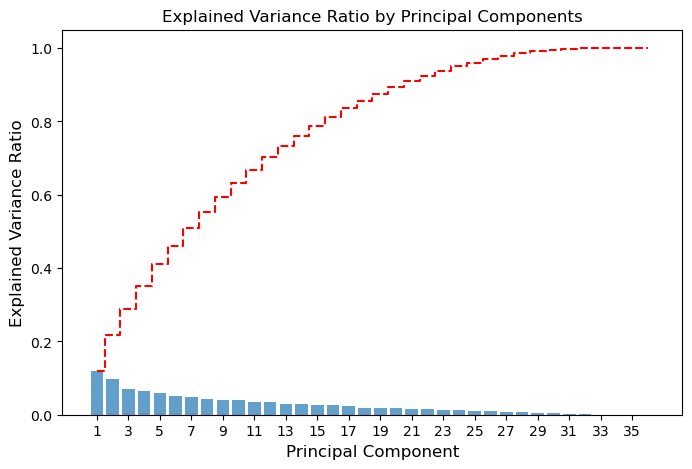

In [1675]:
# Plots a bar chart showing the explained variance ratio for each component and a step plot showing the cumulative explained variance.
plt.figure(figsize=(8, 5))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.7, align='center')
plt.step(range(len(explained_variance_ratio)), explained_variance_ratio.cumsum(), where='mid', linestyle='--', color='red')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Explained Variance Ratio by Principal Components')
plt.xticks(np.arange(0,36,2),np.arange(0,36,2)+1 ) 
plt.show()

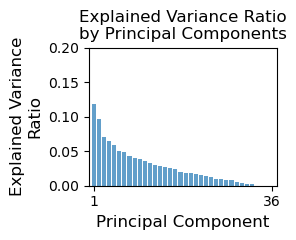

In [1677]:
plt.figure(figsize=(3, 2.5))
plt.bar(range(len(explained_variance_ratio)), explained_variance_ratio, alpha=0.7, align='center')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance\nRatio', fontsize=12)
plt.title('Explained Variance Ratio\nby Principal Components')
plt.xticks([0,35],[1,36]) 
plt.ylim(0,0.2)
plt.xlim(-1,len(explained_variance_ratio))
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_pc_explained variance.png', dpi=300, bbox_inches='tight')
plt.show()

lets take 1st 2 components

In [1678]:
print(principal_components.shape[1])
principal_components = principal_components[:,:2]
print(principal_components.shape[1])

36
2


In [1679]:
k = int(principal_components.shape[0]/n_clusters)

a_pca = principal_components[:k,:]
b_pca = principal_components[k:k+k,:]
c_pca = principal_components[k+k:,:]

centroidd_a_pca = np.mean(a_pca, axis=0).reshape(1, -1)[0]
centroidd_b_pca = np.mean(b_pca, axis=0).reshape(1, -1)[0]
centroidd_c_pca = np.mean(c_pca, axis=0).reshape(1, -1)[0]

a_pca.shape, b_pca.shape, c_pca.shape, centroidd_a_pca.shape

((30, 2), (30, 2), (30, 2), (2,))

In [1680]:
def fit_gaussian(data):
    """Fit a 2D Gaussian to the data and return the mean and covariance."""
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    return mean, cov

def plot_ellipse(mean, cov, ax, n_std=1.0, color='red', **kwargs):
    """Plot an ellipse representing the Gaussian mean ± n_std * standard deviations."""
    # Eigenvalue decomposition to find the axis lengths and rotation angle
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    
    # Width and height are "full" lengths, not radius
    width, height = 2 * n_std * np.sqrt(vals)
    
    ell = patches.Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=None, facecolor=color, alpha=0.35, **kwargs)
    ax.add_patch(ell)

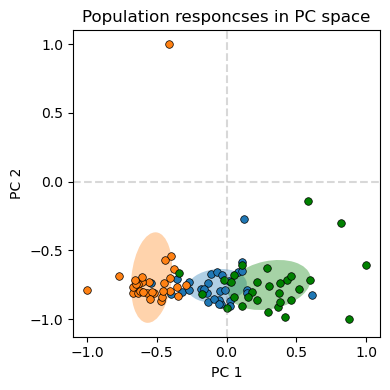

In [1681]:
data_pca = [a_pca[:,:2], b_pca[:,:2], c_pca[:,:2]]
colors = ['#1F77B4', '#FF8113', 'green']
names = ['alpha', 'beta', 'blank']

fig, ax = plt.subplots(figsize=(4, 4))

i = 0
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)
    i+=1

i = 0
for data, color in zip(data_pca, colors):
    # Plot data points
    ax.scatter(data[:, 0], data[:, 1], s=30, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
    i+=1

plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.grid(True)
# plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim(-1,1)
# plt.xlim(-1,1)
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Population responcses in PC space')
# plt.legend()
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_1sd_norm_new.png', dpi=300, bbox_inches='tight')
plt.show() 

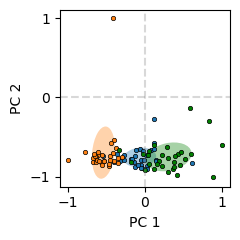

In [1682]:
data_pca = [a_pca[:,:2], b_pca[:,:2], c_pca[:,:2]]
colors = ['#1F77B4', '#FF8113', 'green']
names = ['alpha', 'beta', 'blank']

fig, ax = plt.subplots(figsize=(2.5,2.5))

i = 0
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)
    i+=1

i = 0
for data, color in zip(data_pca, colors):
    # Plot data points
    ax.scatter(data[:, 0], data[:, 1], s=10, color=color, label=names[i], edgecolor='k',  linewidth=0.5)
    i+=1

plt.axvline(0,  linestyle = '--', color='#808080', alpha=0.3)
plt.axhline(0,  linestyle = '--', color='#808080', alpha=0.3)
# plt.grid(True)
# plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.ylim(-1,1)
# plt.xlim(-1,1)
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.title('Population responcses in PC space')
# plt.legend()
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_pca_mini.png', dpi=300, bbox_inches='tight')
plt.show() 

In [1683]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

C:\Users\ebukina\AppData\Local\Temp\ipykernel_9804\1342201787.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade


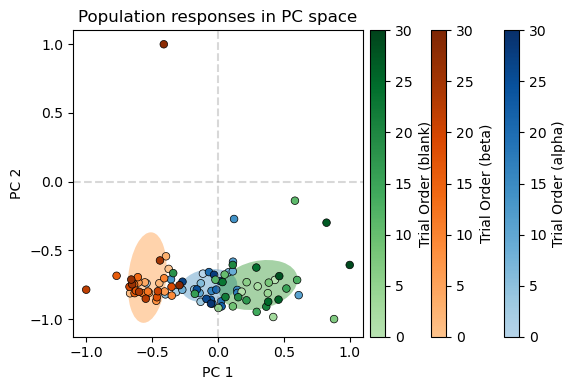

In [1684]:
# Create custom colormaps
def create_custom_cmap(base_cmap):
    colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade
    return LinearSegmentedColormap.from_list(f'{base_cmap}_custom', colors)

data_pca = [a_pca[:,:2], b_pca[:,:2], c_pca[:,:2]]
colors = ['#1F77B4', '#FF8113', 'green']
names = ['alpha', 'beta', 'blank']
base_colormaps = ['Blues', 'Oranges', 'Greens']  # Base colormaps for customization
custom_colormaps = [create_custom_cmap(cmap) for cmap in base_colormaps]

fig, ax = plt.subplots(figsize=(6, 4))

# Plot the ellipses for each cluster
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)

# Plot the data points with gradient colors for each cluster
for data, cmap, name in zip(data_pca, custom_colormaps, names):
    norm = Normalize(vmin=0, vmax=len(data))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colors = sm.to_rgba(range(len(data)))
    
    # Plot data points with gradient color
    ax.scatter(data[:, 0], data[:, 1], s=30, color=colors, label=name, edgecolor='k', linewidth=0.5)

# Adding colorbars for reference
for cmap, name in zip(custom_colormaps, names):
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label(f'Trial Order ({name})')

plt.axvline(0, linestyle='--', color='#808080', alpha=0.3)
plt.axhline(0, linestyle='--', color='#808080', alpha=0.3)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Population responses in PC space')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_pca_clusts_gradient.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ebukina\AppData\Local\Temp\ipykernel_9804\2590989665.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade


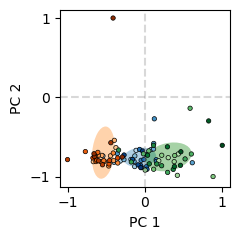

In [1685]:
# Create custom colormaps
def create_custom_cmap(base_cmap):
    colors = plt.cm.get_cmap(base_cmap)(np.linspace(0.3, 1, 256))  # Start from a darker shade
    return LinearSegmentedColormap.from_list(f'{base_cmap}_custom', colors)

data_pca = [a_pca[:,:2], b_pca[:,:2], c_pca[:,:2]]
colors = ['#1F77B4', '#FF8113', 'green']
names = ['alpha', 'beta', 'blank']
base_colormaps = ['Blues', 'Oranges', 'Greens']  # Base colormaps for customization
custom_colormaps = [create_custom_cmap(cmap) for cmap in base_colormaps]

fig, ax = plt.subplots(figsize=(2.5,2.5))

# Plot the ellipses for each cluster
for data, color in zip(data_pca, colors):
    mean, cov = fit_gaussian(data)
    plot_ellipse(mean, cov, ax, color=color)

# Plot the data points with gradient colors for each cluster
for data, cmap, name in zip(data_pca, custom_colormaps, names):
    norm = Normalize(vmin=0, vmax=len(data))
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    colors = sm.to_rgba(range(len(data)))
    
    # Plot data points with gradient color
    ax.scatter(data[:, 0], data[:, 1], s=10, color=colors, label=name, edgecolor='k', linewidth=0.5)

# # Adding colorbars for reference
# for cmap, name in zip(custom_colormaps, names):
#     sm = ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])
#     cbar = plt.colorbar(sm, ax=ax, pad=0.02)
#     cbar.set_label(f'Trial Order ({name})')

plt.axvline(0, linestyle='--', color='#808080', alpha=0.3)
plt.axhline(0, linestyle='--', color='#808080', alpha=0.3)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
# plt.title('Population responcses in PC space')
plt.tight_layout()
plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_pca_clusts_gradient_mini.png', dpi=300, bbox_inches='tight')
plt.show()

## Mahalanobis distance between clusters
1) compute the covariance matrix and the mean vectors for each cluster
2) compute the Mahalanobis distance

In [1686]:
from scipy.spatial.distance import mahalanobis
import scipy.stats as stats
from scipy.stats import percentileofscore
import seaborn as sns
import math

def euclidean(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [1687]:
def calculate_distance(principal_components, n_clusters=3):

    k = int(principal_components.shape[0]/n_clusters)

    a_pca = principal_components[:k,:]
    b_pca = principal_components[k:k+k,:]
    c_pca = principal_components[k+k:,:]

    centroid_a_pca = np.median(a_pca, axis=0).reshape(1, -1)[0]
    centroid_b_pca = np.median(b_pca, axis=0).reshape(1, -1)[0]
    centroid_c_pca = np.median(c_pca, axis=0).reshape(1, -1)[0]

    
    covar = np.cov(principal_components.T)
    covarinv = np.linalg.inv(covar)

    D_aa = np.array([mahalanobis(x, centroid_a_pca, covarinv) for x in a_pca])
    D_ab = np.array([mahalanobis(x, centroid_a_pca, covarinv) for x in b_pca])
    D_ac = np.array([mahalanobis(x, centroid_a_pca, covarinv) for x in c_pca])

    D_bb = np.array([mahalanobis(x, centroid_b_pca, covarinv) for x in b_pca])
    D_ba = np.array([mahalanobis(x, centroid_b_pca, covarinv) for x in a_pca])
    D_bc = np.array([mahalanobis(x, centroid_b_pca, covarinv) for x in c_pca])

    D_cc = np.array([mahalanobis(x, centroid_c_pca, covarinv) for x in c_pca])
    D_ca = np.array([mahalanobis(x, centroid_c_pca, covarinv) for x in a_pca])
    D_cb = np.array([mahalanobis(x, centroid_c_pca, covarinv) for x in b_pca])

    # assemble matrix
    D_matrix = np.zeros((3,3))
    D_matrix[0,0] = np.median(D_aa)
    D_matrix[0,1] = np.median(D_ab)
    D_matrix[0,2] = np.median(D_ac)

    D_matrix[1,0] = np.median(D_ba)
    D_matrix[1,1] = np.median(D_bb)
    D_matrix[1,2] = np.median(D_bc)


    D_matrix[2,0] = np.median(D_ca)
    D_matrix[2,1] = np.median(D_cb)
    D_matrix[2,2] = np.median(D_cc)
    
    
    return D_matrix

In [1688]:
def plot_distance_matrix(D_matrix, D_type = "MD", rotate=False):
    plt.figure(figsize=(2,1.5))

    labels = ['Alpha', 'Beta', 'Blank']

    if D_type=='MD':
        cbar_label = 'Mahalanobis distance'
    else:
        cbar_label = 'Euclidean distance'

    if rotate:
        # Create the heatmap
        heatmap = sns.heatmap(D_matrix, annot=D_matrix, cmap='binary', cbar_kws={'label': cbar_label}, linewidths=1, linecolor='white', square=True, vmin=0, vmax=math.sqrt(8))

        # # Customize the heatmap
        heatmap.set_xticklabels(labels, rotation=0)
        heatmap.set_yticklabels(labels, rotation=90)

        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(rotation=90)

    else:
        # Create the heatmap
        sns.heatmap(D_matrix, annot=D_matrix, cmap='binary', cbar_kws={'label': cbar_label}, linewidths=1, linecolor='white', square=True, vmin=0, vmax=math.sqrt(8))

        # # Customize the heatmap
        plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=0)
        plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, rotation=90)

    plt.title('Distance in PC space\n')
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_{D_type}_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [1689]:
MD_matrix = calculate_distance(principal_components)

In [1690]:
save_path = f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_MD_matrix.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(MD_matrix, f)

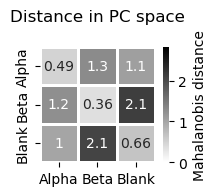

In [1691]:
plot_distance_matrix(MD_matrix)

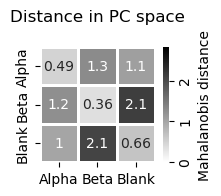

In [1692]:
plot_distance_matrix(MD_matrix,rotate=True)

## Shuffle control

In [1693]:
def dist_shuffle(principal_components, D_type = "MD"):
    ab_sh = []
    ac_sh = []
    bc_sh = []

    idx = np.arange(len(principal_components))

    for shuffle in range(1000):
        np.random.shuffle(idx)
        X_pca_sh = principal_components[idx]
        fr_matrix_a_sh = X_pca_sh[:k,:] # n_trials = 30
        fr_matrix_b_sh = X_pca_sh[k:(k*2),:]
        fr_matrix_c_sh = X_pca_sh[(k*2):,:]

        centroid_a_sh = np.median(fr_matrix_a_sh, axis=0).reshape(1, -1)[0]
        centroid_b_sh = np.median(fr_matrix_b_sh, axis=0).reshape(1, -1)[0]
        centroid_c_sh = np.median(fr_matrix_c_sh, axis=0).reshape(1, -1)[0]
        
        if  D_type == "MD":
            covar_sh = np.cov(X_pca_sh.T)
            covarinv_sh = np.linalg.inv(covar_sh)

            ab_sh.append(mahalanobis(centroid_a_sh, centroid_b_sh,covarinv_sh))
            ac_sh.append(mahalanobis(centroid_a_sh, centroid_c_sh,covarinv_sh))
            bc_sh.append(mahalanobis(centroid_b_sh, centroid_c_sh,covarinv_sh))

        else:
            ab_sh.append(euclidean(centroid_a_sh, centroid_b_sh))
            ac_sh.append(euclidean(centroid_a_sh, centroid_c_sh))
            bc_sh.append(euclidean(centroid_b_sh, centroid_c_sh))

    sh = [ab_sh, ac_sh, bc_sh]

    # Kolmogorov-Smirnov Test
    for xx_sh in sh:
        _, p_D = stats.kstest(xx_sh, 'norm')
        alpha = 0.01
        if p_D > alpha:
            print(f"Distr is normal, p = {p_D:.3f}")
        else:
            print(f"Dist is NOT normal, p = {p_D:.3f}")    

    D_matrix = calculate_distance(principal_components)
    ab = D_matrix[0,1]
    ac = D_matrix[0,2]
    bc = D_matrix[1,2] 
    real_D = [ab,ac,bc]

    p_vals = []
    for i,xx_sh in enumerate(sh):
        D_sh_sorted = np.sort(xx_sh)
        percentile_rank = percentileofscore(D_sh_sorted, real_D[i])
        if percentile_rank>=50:
            p_value = 1-(percentile_rank/100)
        else:
            p_value = percentile_rank/100
        # since i want 2-tailored
        p_value = p_value*2
        p_vals.append(p_value)
    print(p_vals)

    return real_D, sh, p_vals
                


In [1694]:
MD_real, MD_sh, MD_p_vals = dist_shuffle(principal_components)

Dist is NOT normal, p = 0.000
Dist is NOT normal, p = 0.000
Dist is NOT normal, p = 0.000
[0.0, 0.0019999999999997797, 0.0]


In [1695]:
def plot_shuffle(D_real, D_sh, D_p_val, type):
    plt.figure(figsize=(2.3,2.6)) 
    bin_edges = np.arange(np.min(np.array(D_sh)), np.max(np.array(D_sh))+0.02, 0.02)
    plt.hist(D_sh, alpha=0.5, bins=bin_edges, color='#808080')
    plt.axvline(D_real,color='red')
    plt.title(f"{type} between centroids\nD = {D_real:.1f}, p_val = {D_p_val:.3f}\n")
    plt.xlabel('Mahalanobis distance',  fontsize=12)
    plt.ylabel('Count',  fontsize=12)
    plt.tight_layout()
    plt.xlim(0, 2.5)
    plt.ylim(0, 65)
    plt.savefig(f'C:\\Users\\ebukina\\Desktop\\eva\\results\\populational_anal\\{mouse}_S{Session}_D_{type}.png', dpi=300, bbox_inches='tight')
    plt.show()

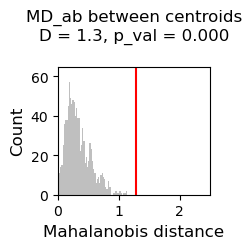

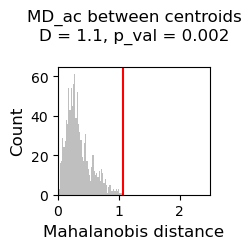

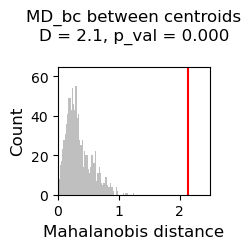

In [1696]:
types = ['MD_ab', 'MD_ac','MD_bc',]
for i in range(3):
    plot_shuffle(MD_real[i], MD_sh[i], MD_p_vals[i], types[i])